In [3]:
# import the necessary python modules
import numpy as np
import time
import corner
import matplotlib.pyplot as plt
import matplotlib
import os
import copy
import astropy.io.fits as pyfits


from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Plots.output_plots as lens_plot

from lenstronomy.Util import constants

from lenstronomy.ImSim.image_model import ImageModel

from lenstronomy.PointSource.point_source import PointSource

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions

from lenstronomy.LightModel.light_model import LightModel

from lenstronomy.Sampling.parameters import Param

from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

from lenstronomy.Cosmo.lens_cosmo import LensCosmo

from astropy.cosmology import FlatLambdaCDM

import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
import lenstronomy.Util.param_util as param_util
#DATOS RUNG-0

#### LENTE SPEMD #####
q = 0.787
phi=1.605
#q = 0.028
#phi=2.225

#Transformacion
e1, e2 = param_util.phi_q2_ellipticity(phi=phi, q=q)
c = (e1**2+e2**2)**(0.5)

#### LENS LIGHT #####
ql=0.969
phil=1.731
#Transformacion
el1, el2 = param_util.phi_q2_ellipticity(phi=phil, q=ql)

#### SOURCE LIGHT ####
qs = 0.853
phis = 2.805
#Transformacion
es1, es2 = param_util.phi_q2_ellipticity(phi=phis, q=qs)

#comparativo de elipticidad del SHEAR

qsh = 0.028
phish = 2.225
#Transformacion
esh1, esh2 = param_util.phi_q2_ellipticity(phi=phish, q=qsh)

#tomando opcion gamma
gamma = 0.225029


print(e1,e2)
print(c,(1-c)/(1+c))
print(el1,el2)
print(es1,es2)
print(esh1,esh2)

-0.11891540047022357 -0.008147399722318508
0.119194180190263 0.7870000000000001
-0.014942774634311954 -0.0049586334517848045
0.062023977480313 -0.0494611403971758
-0.2452583897971951 -0.9131628549837169


image positions are:  [ 1.30960709 -1.27082143  0.04583093 -0.10792881] [ 0.13134335 -0.13000975 -1.01968268  1.01242116]
point source magnification:  [ 2.38286358  2.49730141 -1.48339757 -1.47957516]
source size in arcsec:  0.0012088539502485196
finite magnification:  [2.38287803 2.49732032 1.48341426 1.47959188]
time delays:  [-163.98484204 -154.86736558 -100.90019025 -100.71656164]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in log10


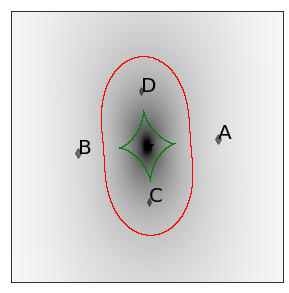

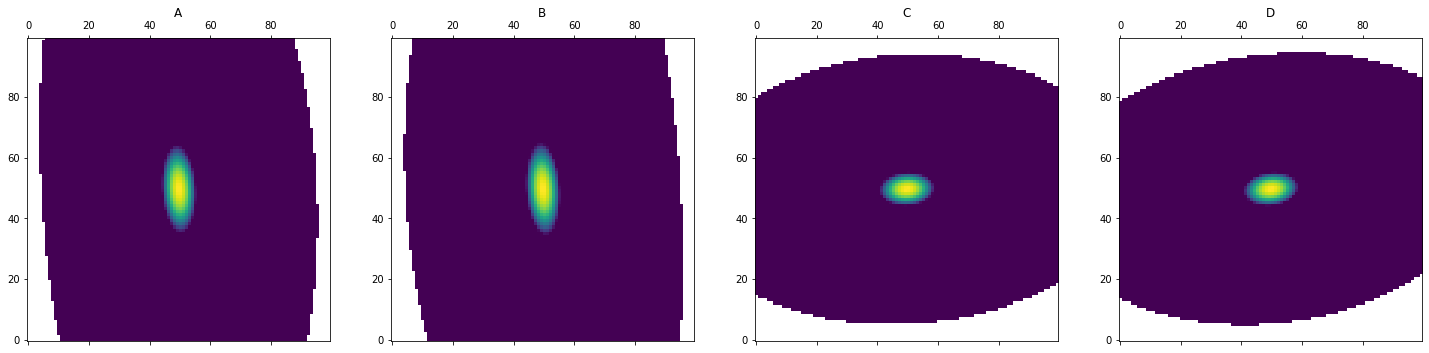

In [10]:
# the redshifts of lens and source and the cosmology is only used when predicting the relative time delays between the images
z_lens = 0.858
z_source = 2.175

cosmo = FlatLambdaCDM(H0=72.032, Om0=0.27, Ob0=0.)
lensCosmo = LensCosmo(cosmo=cosmo, z_lens=z_lens, z_source=z_source)


# make class instances for a chosen lens model type

# chose a lens model
lens_model_list = ['SPEP', 'SHEAR']
# make instance of LensModel class
lensModel = LensModel(lens_model_list=lens_model_list, cosmo=cosmo, z_lens=z_lens, z_source=z_source)
# we require routines accessible in the LensModelExtensions class
lensModelExtensions = LensModelExtensions(lensModel=lensModel)
# make instance of LensEquationSolver to solve the lens equation
lensEquationSolver = LensEquationSolver(lensModel=lensModel)

# make choice of lens model

# we chose a source position (in units angle) 

#conflicto aqui definimos si las posiciones en x y y son iguales a las declinaciones y las ascensiones rectas
x_source, y_source = 0.02, 0.001
# we chose a lens model
#kwargs_lens = [{'theta_E':1.161,'gamma':2.044,'center_x':0,'center_y':0,'e1':e1,'e2':e2},
              #{'e1': 0.007, 'e2': 0.027}]

#como practica definiendo manual
kwargs_spemd = {'theta_E':1.161,'gamma':2.044,'center_x':0,'center_y':0,'e1':e1,'e2':e2}
kwargs_shear = {'e1': 0.007, 'e2': 0.027}
kwargs_lens = [kwargs_spemd, kwargs_shear]

# compute image positions and their (finite) magnifications

# we solve for the image position(s) of the provided source position and lens model
x_img, y_img = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens, sourcePos_x=x_source, 
                                                             sourcePos_y=y_source)
print('image positions are: ', x_img, y_img)
# the infinitesimal magnification at the position of the images is:
mag_inf = lensModel.magnification(x_img, y_img, kwargs_lens)
print('point source magnification: ', mag_inf)


# we chose a finite source size of the emitting 'point source' region
source_size_pc = 10. # Gaussian source size in units of parsec
# we convert the units of pc into arcseconds given the redshift of the lens and the cosmology
D_s = lensCosmo.D_s
source_size_arcsec = source_size_pc / 10**6 / D_s / constants.arcsec
print('source size in arcsec: ', source_size_arcsec)

# we compute the finite magnification by rendering a grid around the point source position and add up all the flux coming from the extended source in this window
window_size = 0.1  # units of arcseconds
grid_number = 100  # supersampled window (per axis)

# and here are the finite magnifications computed
mag_finite = lensModelExtensions.magnification_finite(x_pos=x_img, y_pos=y_img, kwargs_lens=kwargs_lens, 
                                                      source_sigma=source_size_arcsec, window_size=window_size,
                                                      grid_number=grid_number)
print('finite magnification: ', mag_finite)



# here are the predicted time delays in units of days
t_days = lensModel.arrival_time(x_img, y_img, kwargs_lens)
print('time delays: ', t_days)

# here we plot the lens model, including (optional) the caustics and critical curves
f, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens, sourcePos_x=x_source, sourcePos_y=y_source, point_source=True, with_caustics=True)
f.show()


# here we plot the finite sources as seen at the different image positions
f, axes = plt.subplots(1, len(x_img), figsize=(5*5, 5*len(x_img)), sharex=False, sharey=False)
label_list = ['A', 'B', 'C', 'D']
for i in range(len(x_img)):
    image = lensModelExtensions.zoom_source(x_pos=x_img[i], y_pos=y_img[i], kwargs_lens=kwargs_lens, 
                                                      source_sigma=source_size_arcsec, window_size=window_size,
                                                      grid_number=grid_number)
    ax = axes[i]
    ax.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')
    ax.set_title(label_list[i])
plt.show()

In [4]:
# import the LightModel class #
from lenstronomy.LightModel.light_model import LightModel

##### SOURCE ######
# set up the list of light models to be used #
# Definiendo modelo de luz del medio
source_light_model_list = ['SERSIC_ELLIPSE']
lightModel_source = LightModel(light_model_list=source_light_model_list)

##### LENTE ######
#Definiendo modelo de luz del lente
lens_light_model_list = ['SERSIC_ELLIPSE']
lightModel_lens = LightModel(light_model_list=lens_light_model_list)


##### SOURCE LIGHT #####
#Ubicacion de la luz
ra_source, dec_source = 0.02, 0.001
#Parametro Luz del medio
qs = 0.853
phis = 2.805
#Transformacion
es1, es2 = param_util.phi_q2_ellipticity(phi=phis, q=qs)
# define the parameters #
kwargs_light_source = {'amp':4000,'R_sersic':0.338,'n_sersic':2.582,'center_x':ra_source, 
                         'center_y':dec_source, 'e1':es1, 'e2':es2}
#kwargs_light_source = [{'amp': 5000, 'R_sersic': 0.02, 'n_sersic': 1.5, 'center_x': beta_ra, 'center_y': beta_dec}]


###### LIGHT LENS #####
#Parametros luz del lente
ql=0.969
phil=1.731
#Transformacion
el1, el2 = param_util.phi_q2_ellipticity(phi=phil, q=ql)
kwargs_light_lens = [{'amp': 400, 'R_sersic': 0.991, 'n_sersic': 3.786, 'center_x': 0, 
                         'center_y': 0,'e1':el1,'e2':el2}]

# evaluate surface brightness at a specific position #
flux = lightModel_lens.surface_brightness(x=1, y=1, kwargs_list=kwargs_light_lens)

In [5]:
# import the PixelGrid() class #
from lenstronomy.Data.pixel_grid import PixelGrid
deltaPix = 0.08  # size of pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
ra_at_xy_0, dec_at_xy_0 = -2.5, -2.5 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': 99, 'ny': 99,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  
                'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates
# compute pixel value of a coordinate position #
x_pos, y_pos = pixel_grid.map_coord2pix(ra=0, dec=0)
# compute the coordinate value of a pixel position #
ra_pos, dec_pos = pixel_grid.map_pix2coord(x=20, y=10)

# import the PSF() class #
from lenstronomy.Data.psf import PSF
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.1, 'pixel_size': deltaPix}
psf = PSF(**kwargs_psf)
# return the pixel kernel corresponding to a point source # 
kernel = psf.kernel_point_source

In [6]:
# import the PointSource class #
from lenstronomy.PointSource.point_source import PointSource
# libreria que me determina lo valores de theta
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

# unlensed source positon #
point_source_model_list = ['SOURCE_POSITION']
pointSource = PointSource(point_source_type_list=point_source_model_list, lensModel=lensModel, fixed_magnification_list=[True])


# se hace el primer cambio importante se definen la ascencion recta y declinacion en el plano de la imagen,
# mediante estos valores determinamos theta ********************.
# Llammamos la ecuacion de lente y determinamos theta a partir de beta que de acuerdo a esta primera aproximacion
# son ascenciones y declinaciones
solver = LensEquationSolver(lensModel)

beta_ra = ra_source
beta_dec = dec_source

theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens)
#beta_ra, beta_dec = lensModel.ray_shooting(theta_ra, theta_dec, kwargs_lens)
kwargs_ps = [{'ra_source': beta_ra, 'dec_source': beta_dec, 'source_amp': 100}]
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

# return image positions and amplitudes #
x_pos, y_pos = pointSource.image_position(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)
point_amp = pointSource.image_amplitude(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)

# lensed image positions (solution of the lens equation) #
point_source_model_list = ['LENSED_POSITION']
pointSource = PointSource(point_source_type_list=point_source_model_list, lensModel=lensModel, fixed_magnification_list=[False])
kwargs_ps = [{'ra_image': theta_ra, 'dec_image': theta_dec, 'point_amp': np.abs(mag)*30}]
# return image positions and amplitudes #
x_pos, y_pos = pointSource.image_position(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)
point_amp = pointSource.image_amplitude(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)

In [7]:
# import the ImageModel class #
from lenstronomy.ImSim.image_model import ImageModel
# define the numerics #
kwargs_numerics = {'supersampling_factor': 1, # each pixel gets super-sampled (in each axis direction) 
                  'supersampling_convolution': False}
# initialize the Image model class by combining the modules we created above #
imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        point_source_class=pointSource, 
                        kwargs_numerics=kwargs_numerics)
# simulate image with the parameters we have defined above #
image = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens, kwargs_ps=kwargs_ps)

# we can also add noise #
import lenstronomy.Util.image_util as image_util
exp_time = 100  # exposure time to quantify the Poisson noise level
background_rms = 0.1  # background rms value
poisson = image_util.add_poisson(image, exp_time=exp_time)
bkg = image_util.add_background(image, sigma_bkd=background_rms)
image_noisy = image + bkg + poisson


KeyError: 0